Import libraries:

In [6]:
import numpy as np
import pandas as pd
import matplotlib

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics as metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display
%matplotlib inline

## Automated Breast Cancer Detection

In this homework, we will consider the problem of early breast cancer detection from X-ray images. Specifically, given a candidate region of interest (ROI) from an X-ray image of a patient's breast, the goal is to predict if the region corresponds to a malignant tumor (label 1) or is normal (label 0). The training and test data sets for this problem is provided in the file `hw6_dataset.csv`. Each row in these files corresponds to a ROI in a patient's X-ray, with columns 1-117 containing features computed using standard image processing algorithms. The last column contains the class label, and is based on a radiologist's opinion or a biopsy. This data was obtained from the KDD Cup 2008 challenge.

The data set contain a total of 69,098 candidate ROIs, of which only 409 are malignant, while the remaining are all normal. 

*Note*: be careful of reading/treating column names and row names in this data set.

## Question 1: Beyond Classification Accuracy


0.  Split the data set into a training set and a testing set.  The training set should be 75% of the original data set, and the testing set 25%.  Use `np.random.seed(9001)`.

1. Fit a logistic regression classifier to the training set and report the  accuracy of the classifier on the test set. You should use $L_2$ regularization in logistic regression, with the regularization parameter tuned using cross-validation. 
    1. How does the fitted model compare with a classifier that predicts 'normal' (label 0) on all patients? 
    2. Do you think the difference in the classification accuracies are large enough to declare logistic regression as a better classifier than the all 0's classifier? Why or why not?
    
For applications with imbalanced class labels, in this case when there are many more healthy subjects ($Y=0$) than those with cancer ($Y=1$), the classification accuracy may not be the best metric to evaluate a classifier's performance. As an alternative, we could analyze the confusion table for the classifier. 

<ol start="3">
<li> Compute the confusion table for both the fitted classifier and the classifier that predicts all 0's.</li>
<li> Using the entries of the confusion table compute the *true positive rate* and the *true negative rate* for the two classifiers. Explain what these evaluation metrics mean for the specific task of cancer detection. Based on the observed metrics, comment on whether the fitted model is better than the all 0's classifier.</li>
<li> What is the *false positive rate* of the fitted classifier, and how is it related to its true positive and true negative rate? Why is a classifier with high false positive rate undesirable for a cancer detection task?</li>
</ol>
*Hint:* You may use the `metrics.confusion_matrix` function to compute the confusion matrix for a classification model.

The difference between the two models is substantial in light of the number of patients. The fraction of a percent that 
the logistic scored higher translates to a number of missclassifications. Further the number of false negatives is 
decreased from 104 to 1. This is the number of people who tested negative despite having cancer, the costliest error 
for our purposes. Having a classifier that predicts all people to not have cancer surely has a high accuracy rate given 
the rarity of cancer, but it does nothing to help find those rare cases that are so critical to find. On the other extreme are
false positives. Predicting all positive makes sure that we find all cases of cancer by predicting that everyone has it. This
is also useless as it does nothing to screen patients. False positives in cancer can cause patient anxiety and monetary costs for 
further tests, while false negatives are lethal.


In [10]:
#Split the data set into a training set and a testing set
np.random.seed(9001)
df = pd.read_csv('hw6_dataset.csv')
msk = np.random.rand(len(df)) < 0.75
data_train = df[msk]
data_test = df[~msk]
orig_columns = list(data_train.columns.values)
new_columns = []
for x in range (len(orig_columns) - 1):
    #print(orig_columns[x])
    index_of_e = orig_columns[x].index('e')
    revised_string = orig_columns[x][:index_of_e + 4]
    #print(revised_string)
    converted_string = float(revised_string)
    new_columns.append(str(converted_string))
new_columns.append('Class Label')
#print(new_columns)
data_train.columns = new_columns
data_test.columns = new_columns
data_train.head(10)

y_train = data_train['Class Label'].values
X_train = data_train.values
y_train = y_train.reshape(len(y_train), 1)

y_test = data_test['Class Label'].values
X_test = data_test.values
y_test = y_test.reshape(len(y_test), 1)



In [11]:
df.head()

,-1.439999999999999891e-01,-1.429999999999999882e-01,-1.160000000000000059e-01,-1.029999999999999943e-01,2.260000000000000064e-01,2.099999999999999922e-01,-9.799999999999999822e-01,-7.800000000000000266e-01,-4.739999999999999769e-01,-4.470000000000000084e-01,...,9.250000000000000444e-01,5.160000000000000142e-01,3.439999999999999725e-01,9.060000000000000275e-01,-1.129999999999999893e+00,-5.520000000000000462e-01,5.530000000000000471e-01,-4.169999999999999818e-01,2.560000000000000053e-01,0.000000000000000000e+00
0,-0.01100,0.138,-0.2230,-0.1730,0.188,0.284,-0.0522,-0.256,0.129,0.427,...,-0.593,0.452,0.00785,-0.533,-0.0789,0.705,0.906,0.216,-0.0723,0.0
1,0.21200,-0.313,0.2660,0.2320,-1.190,-1.150,-1.8100,-1.560,-1.250,-1.200,...,-0.816,1.570,0.39400,1.340,-1.1800,-2.700,-0.926,-2.650,-0.0447,0.0
2,0.21500,-0.184,0.0274,0.0494,0.443,0.463,-1.0500,-0.941,-0.531,-0.394,...,0.634,0.111,0.37100,0.859,-0.9930,-0.492,0.363,0.326,-0.0528,0.0
3,0.27900,-0.197,0.1270,0.0973,-0.213,-0.150,-1.3200,-0.994,-1.110,-1.090,...,-0.640,0.485,0.29500,0.403,-1.1200,-0.343,0.468,-0.820,0.4350,0.0
4,0.00922,-0.138,0.1690,0.1540,-0.391,-0.397,-1.6900,-1.450,-0.546,-0.527,...,-0.277,0.699,0.37100,0.481,-1.0600,-0.526,0.550,-0.284,0.1550,0.0


In [13]:
np.random.seed(9001)

In [14]:
msk = np.random.rand(len(df)) < 0.75
msk

array([ True, False, False, ...,  True, False,  True])

In [15]:
data_train = df[msk]
data_test = df[~msk]
orig_columns = list(data_train.columns.values)
new_columns = []

In [16]:
for x in range (len(orig_columns) - 1):
    #print(orig_columns[x])
    index_of_e = orig_columns[x].index('e')
    revised_string = orig_columns[x][:index_of_e + 4]
    #print(revised_string)
    converted_string = float(revised_string)
    new_columns.append(str(converted_string))
new_columns.append('Class Label')

In [17]:
print(new_columns)

['-0.144', '-0.143', '-0.116', '-0.103', '0.226', '0.21', '-0.98', '-0.78', '-0.474', '-0.447', '-0.143', '-0.0524', '0.26', '0.209', '-0.212', '0.57', '-0.939', '-0.398', '0.395', '0.414', '0.00498', '1.31', '-0.955', '0.706', '0.952', '0.81', '1.01', '-0.66', '0.813', '-0.429', '1.54', '0.171', '0.825', '0.755', '0.15', '0.505', '-0.235', '-0.219', '-0.128', '-1.03', '0.16', '0.259', '0.321', '0.536', '-0.466', '-0.25', '-1.27', '-0.744', '-0.736', '-1.24', '-0.726', '-1.39', '-0.631', '-0.0929', '-0.0882', '-0.0834', '-0.0745', '0.471', '0.907', '-0.749', '-1.24', '-0.741', '-0.72', '-0.707', '-0.698', '0.0627', '0.32', '-0.483', '0.677', '0.728', '-1.23', '0.776', '-0.669', '-0.159', '-0.162', '-0.169', '-0.656', '0.953', '0.408', '-0.982', '-0.986', '-0.137', '0.179', '0.267', '0.28', '-1.23', '-1.21', '-1.19', '0.448', '1.55', '1.55', '1.55', '0.357', '-0.945', '-0.137', '-1.28', '-1.41', '-0.896', '-0.667', '-1.01', '-0.56', '-0.563', '-0.566', '-0.804', '-0.618', '0.0344', '0.4

In [18]:
data_train.columns = new_columns
data_test.columns = new_columns

data_train.head()

,-0.144,-0.143,-0.116,-0.103,0.226,0.21,-0.98,-0.78,-0.474,-0.447,...,0.925,0.516,0.344,0.906,-1.13,-0.552,0.553,-0.417,0.256,Class Label
0,-0.0110,0.138,-0.223,-0.1730,0.188,0.284,-0.0522,-0.256,0.129,0.427,...,-0.593,0.4520,0.00785,-0.533,-0.0789,0.705,0.906,0.216,-0.0723,0.0
3,0.2790,-0.197,0.127,0.0973,-0.213,-0.150,-1.3200,-0.994,-1.110,-1.090,...,-0.640,0.4850,0.29500,0.403,-1.1200,-0.343,0.468,-0.820,0.4350,0.0
5,0.0569,0.192,0.302,0.2720,-0.484,-0.473,0.3480,0.256,-0.607,-0.355,...,0.206,-0.0599,-1.07000,-0.536,0.8640,0.527,0.282,0.817,-0.2830,0.0
6,0.0184,0.101,-0.681,-0.5900,1.530,1.500,-0.5560,-0.428,-0.583,-0.772,...,0.124,0.3070,0.35700,-0.380,0.1580,0.846,0.704,0.760,-0.1250,0.0
9,-0.0748,-0.432,0.923,0.7930,-1.040,-1.010,-1.9500,-1.560,-0.590,-0.575,...,-1.270,1.3600,0.38700,1.290,-1.2100,-2.050,-0.357,-2.540,0.7670,0.0


In [19]:
y_train = data_train['Class Label'].values
X_train = data_train.values

In [20]:
y_test = data_test['Class Label'].values
X_test = data_test.values

In [21]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)

c:\users\91998\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [22]:
print('\n')
print("The coefficients")
print("The optimized L2 regularization paramater id:", clf.coef_)
print('Estimated beta0: \n', clf.intercept_)



The coefficients
The optimized L2 regularization paramater id: [[-5.44112659e-03  6.80650028e-04  3.09151185e-01  2.66953923e-01
  -1.84133578e-01 -1.66968937e-01  7.06328168e-02 -9.76875503e-04
   5.53104700e-02 -3.22575843e-02 -2.99078374e-02  7.84676694e-02
  -1.18637126e-01  1.52506089e-02  2.05448177e-02 -1.68288475e-02
  -5.53465474e-02 -5.91006256e-02 -7.16507945e-02 -4.36696153e-02
   8.61663605e-02  3.19947405e-02  5.75566827e-02 -2.36848033e-02
   1.59849214e-01 -1.73521969e-02  2.18425051e-02 -6.60583536e-02
  -6.52913395e-03 -2.83762166e-02 -1.57706221e-02  2.74831894e-02
   1.16871222e-01  4.17356520e-02  4.09838155e-02 -3.16392824e-02
   4.34994443e-02  3.88653412e-02 -1.36868075e-02 -2.00794914e-02
   8.78438585e-03  1.85816938e-02  2.39887017e-02 -2.89970354e-02
   8.17872073e-03  1.46585751e-02  5.59168233e-02 -1.06716367e-01
  -1.03819009e-01 -3.72279609e-02 -1.05758898e-01  5.48134209e-02
   1.74203154e-02 -2.94514578e-02 -2.35360147e-02 -1.97738756e-02
  -1.385769

In [23]:
#scoring
clf_y_pred_test = clf.predict(X_test)
test_df = pd.DataFrame(clf_y_pred_test)

In [24]:
Total = test_df[0].sum()
print('\n')
print("malignant: ", Total)



malignant:  103.0


In [25]:
test_df['All Normal'] = 0

In [26]:
# Reset indexes so copy will work
test_df = test_df.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)
test_df['Class Label'] = data_test['Class Label']

In [27]:
def parameters(source_data, prediction_data):
    false_negative = 0
    false_positive = 0
    correct_assessment = 0
    for result in range(0, len(prediction_data)):
        if int(prediction_data[result]) == 1 and int(source_data[result]) == 0:
            false_positive += 1
        if int(prediction_data[result]) == 0 and int(source_data[result]) == 1:
            false_negative += 1
        if (int(prediction_data[result]) == 1 and int(source_data[result]) == 1) or (int(prediction_data[result]) == 0 and int(source_data[result]) == 0):
            correct_assessment += 1
    print ()
    print ("False Positives: ", false_positive)
    print ("False Negatives: ", false_negative)
    print ("Correct Assessment: ", correct_assessment)

    print ("Classification Accuracy: ", 1 - (false_positive + false_negative) / len(source_data))

In [28]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
print('\n')
print('Classifier applied to Test Set:') 
parameters(test_df['Class Label'], test_df[0])
print(confusion_matrix(y_test, clf.predict(X_test)))



Classifier applied to Test Set:

False Positives:  0
False Negatives:  1
Correct Assessment:  17087
Classification Accuracy:  0.9999414794007491
[[16984     0]
 [    1   103]]


In [29]:
print('\n')
print('Classifier that predicts all normal:')
parameters(test_df['Class Label'], test_df['All Normal'])
print(confusion_matrix(y_test, test_df['All Normal']))



Classifier that predicts all normal:

False Positives:  0
False Negatives:  104
Correct Assessment:  16984
Classification Accuracy:  0.9939138576779026
[[16984     0]
 [  104     0]]


## Question 2: ROC Analysis

Another powerful diagnostic tool for class-imbalanced classification tasks is the Receiver Operating Characteristic (ROC) curve. Notice that the default logistic regression classifier in `sklearn` classifies a data point by thresholding the predicted class probability $\hat{P}(Y=1)$ at 0.5. By using a different threshold, we can adjust the trade-off between the true positive rate (TPR) and false positive rate (FPR) of the classifier. The ROC curve allows us to visualize this trade-off across all possible thresholds.


1. Display the ROC curve for the fitted classifier on the *test set*. In the same plot, also display the ROC curve for the all 0's classifier. How do the two curves compare?

2.  Compute the highest TPR that can be achieved by the classifier at each of the following FPR's, and the thresholds at which they are achieved. Based on your results, comment on how the threshold influences a classifier's FPR.
    - FPR = 0
    - FPR = 0.1
    - FPR = 0.5
    - FPR = 0.9
- Suppose a clinician told you that diagnosing a cancer patient as normal is *twice* as critical an error as diagnosing a normal patient as having cancer. Based on this information, what threshold would you recommend the clinician to use? What is the TPR and FPR of the classifier at this threshold? 

- Compute the area under the ROC curve (AUC) for both the fitted classifier and the all 0's classifier. How does the difference in the AUCs of the two classifiers compare with the difference between their classification accuracies in Question 1, Part 2(A)? 

*Hint:* You may use the `metrics.roc_curve` function to compute the ROC curve for a classification model and the `metrics.roc_auc_score` function to compute the AUC for the model.

As explained above, the logistic model is much better and here is the visualization of that. The curve of the logistic is steep
getting us to 1 tpr quickly while taking on few false positives. On the otherhand, our all negative model takes on false positives as quickly as it takes on true positives, not as effective for our purposes. the area under the curve for the logistic
is 1 whereas the auc for the all negative model is 1/2. This seems to be a better measure of the models accuracy.  The gap in aucs demonstrates the effective difference in these models better than the classification accuracy score, the scores being so close together +.999. The models are in truth very different and AUC reflects this difference.
In computing the roc curve, we ended up with arrays of 11 values. 11 fprs, 11 tprs and 11 thresholds.
We searched through these lists for the value that was equal to or larger than the given fprs, 0, .1, .5, and .9
Our results printed below are the next highest values of fpr that satisfy that condition. Our curve is very steep and goes all the way to 1 quickly. What this tells us is that a threshold just above zero, gives us a tpr of 1.
If we were using this for cancer detection, we would use a low threshold, such as FPR: 0.0314413565709 TPR 1.0 Threshold 0.000580536840768(from below). This takes on very little false positives while simulateously giving us all true positives.

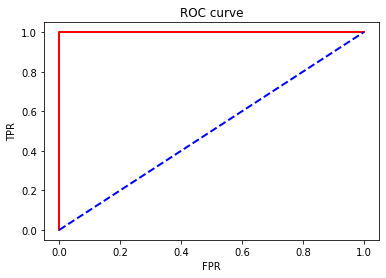

In [30]:
from sklearn import metrics
##Computing false and true positive rates
fpr, tpr,_= metrics.roc_curve(clf.predict(X_train),y_train,drop_intermediate=False)

import matplotlib.pyplot as plt
plt.figure()
##Adding the ROC
plt.plot(fpr, tpr, color='red',
 lw=2, label='ROC curve')
##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

In [31]:
len(clf.predict_proba(X_test)[:,1])

17088

In [32]:
fprs = [0,.1,.5,.9]
fpr, tpr, thresholds= metrics.roc_curve(y_test, clf.predict_proba(X_test)[:,1])

In [33]:
print("fpr ", fpr)

fpr  [0.00000000e+00 0.00000000e+00 0.00000000e+00 5.88789449e-05
 5.88789449e-05 3.47385775e-02 3.48563354e-02 1.16933585e-01
 1.17051342e-01 5.95089496e-01 5.95207254e-01 8.25836081e-01
 8.25953839e-01 1.00000000e+00]


In [34]:
print("tpr ", tpr)

tpr  [0.         0.00961538 0.99038462 0.99038462 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ]


In [35]:
print("thresholds: ", thresholds)

thresholds:  [1.99971864e+00 9.99718640e-01 6.52279017e-01 1.83779207e-01
 1.20818814e-01 5.07325557e-04 5.06839421e-04 2.35321108e-04
 2.35225264e-04 3.35102441e-05 3.34997470e-05 1.07109019e-05
 1.07066776e-05 4.84564917e-41]


## Question 3: Missing data

In this problem you are given a different data set, `hw6_dataset_missing.csv`, that is  similar to the one you used above (same column definitions and same conditions), however this data set contains missing values. 

*Note*: be careful of reading/treating column names and row names in this data set as well, it *may* be different than the first data set.


1. Remove all observations that contain and missing values, split the dataset into a 75-25 train-test split, and fit the regularized logistic regression as in Question 1 (use `LogisticRegressionCV` again to retune).  Report the overall classification rate and TPR in the test set.
2. Restart with a fresh copy of the data in `hw6_dataset_missing.csv` and impute the missing data via mean imputation.  Split the data 75-25 and fit the regularized logistic regression model.  Report the overall classification rate and TPR in the test set.  
3. Again restart with a fresh copy of the data in `hw6_dataset_missing.csv` and impute the missing data via a model-based imputation method. Once again split the data 75-25 and fit the regularized logistic regression model.  Report the overall classification rate and TPR in the test set.  
4. Compare the results in the 3 previous parts of this problem.  Prepare a paragraph (5-6 sentences) discussing the results, the computational complexity of the methods, and conjecture and explain why you get the results that you see.



In [44]:
np.random.seed(9001)
df = pd.read_csv('HW6_dataset_missing.csv')
msk = np.random.rand(len(df)) < 0.75
data_train = df[msk]
data_test = df[~msk]
data_train = data_train.dropna()
data_test = data_test.dropna()

In [45]:
df.head()

,Unnamed: 0,1,2,3,4,5,6,7,8,9,...,109,110,111,112,113,114,115,116,117,type
0,0,0.1290,-0.2160,0.2880,0.2370,-0.993,-0.9550,-1.620,-1.470,-1.0100,...,-1.1900,1.1000,0.395,2.060,-1.180,-2.8500,-1.290,-2.100,0.0121,0.0
1,1,0.0989,0.1160,0.3130,0.2810,-0.188,-0.2790,0.173,0.445,0.4320,...,-0.0181,0.2480,-0.869,-0.190,0.451,0.6980,0.363,1.030,-0.2490,0.0
2,2,0.0215,0.1590,0.5790,0.5020,-0.342,-0.2740,-0.172,-0.164,0.2160,...,0.0702,0.0200,0.397,-0.800,0.173,0.7380,0.465,0.440,-0.2880,0.0
3,3,-0.2170,-0.3570,-0.0539,-0.0688,0.445,0.6380,0.436,0.351,0.0401,...,NaN,0.0622,0.269,-0.217,-1.030,0.0276,0.472,-0.390,0.3660,0.0
4,4,-0.0846,0.0166,0.4240,0.3520,-0.259,-0.0947,0.119,-0.162,0.3020,...,0.7190,0.3250,-0.286,-0.528,-0.704,0.8530,0.953,-0.116,-0.1190,0.0


In [46]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

In [47]:
y_train = data_train['type'].values
X_train = data_train.values
y_train = y_train.reshape(len(y_train), 1)

y_test = data_test['type'].values
X_test = data_test.values
y_test = y_test.reshape(len(y_test), 1)

In [48]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)

c:\users\91998\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\91998\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [49]:
# L2 Regularization parameter
print('\n')
# print("The optimized L2 regularization paramater id:", clf.C_)

# The coefficients
print('Estimated beta1: \n', clf.coef_)
print('Estimated beta0: \n', clf.intercept_)

# Metrics
print('\n')
print('Test Set Confusion matrix:') 
print(confusion_matrix(y_test, clf.predict(X_test)))

train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)
y_prediction = clf.predict(X_test)
test_precision = precision_score(y_test, y_prediction)
print('The training classification accuracy is: ', train_score)
print('The testing classification accuracy is: ', test_score)
print('The precision score on the test set is: ', test_precision)



Estimated beta1: 
 [[-4.28070857e-04  5.13161019e-03 -8.24770795e-02  2.62166682e-02
   9.71373525e-03 -1.57700561e-01 -1.32623309e-01  3.38311234e-02
  -1.65652323e-01  6.14399667e-01  1.63531540e-01 -3.16943672e-01
  -2.25668044e-01 -1.86757287e-01  1.83250624e-01 -1.69438387e-01
  -9.01949716e-02 -2.24131696e-01 -3.25742611e-01  1.96410965e-02
  -5.16950506e-01 -4.33760660e-01 -7.88831844e-02  1.43639449e-01
   1.89435541e-01  1.62229394e-01 -6.08755908e-03  1.04805606e-01
   4.22719805e-02  1.25644614e-01  2.49082665e-02  2.05272438e-01
   2.66141454e-01  7.24761342e-02  9.69340277e-02 -1.74576911e-01
  -1.11861524e-01  3.55179686e-02  4.46740966e-02  1.07715299e-01
   1.57445398e-01  2.04111837e-02  2.85547557e-02  4.90255145e-02
  -8.15037912e-02 -8.39936006e-02 -5.16447975e-02  1.73432556e-01
   4.08859263e-02  4.88968852e-02 -1.22702986e-01  4.43732856e-02
  -2.36096055e-01 -2.02251049e-02  2.55592515e-02  1.62965873e-02
   9.38534258e-03 -1.62747851e-03  1.33159637e-01 -2.04

In [50]:
#Split the data set into a training set and a testing set
np.random.seed(9001)
df_2 = pd.read_csv('HW6_dataset_missing.csv')
msk = np.random.rand(len(df)) < 0.75
data_train_2 = df_2[msk]
data_test_2 = df_2[~msk]

In [51]:
for column in data_train_2:
    data_train_2[column] = data_train_2[column].fillna(data_train_2[column].mean())
for column in data_test_2:
    data_test_2[column] = data_test_2[column].fillna(data_train_2[column].mean())
    
y_train = data_train_2['type'].values
X_train = data_train_2.values
y_train = y_train.reshape(len(y_train), 1)

y_test = data_test_2['type'].values
X_test = data_test_2.values
y_test = y_test.reshape(len(y_test), 1)

c:\users\91998\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\91998\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [52]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)


# L2 Regularization parameter
print('\n')
# print("The optimized L2 regularization paramater id:", clf.C_)

# The coefficients
print('Estimated beta1: \n', clf.coef_)
print('Estimated beta0: \n', clf.intercept_)

# Metrics
print('\n')
print('Test Set Confusion matrix:') 
print(confusion_matrix(y_test, clf.predict(X_test)))

train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)
y_prediction = clf.predict(X_test)
test_precision = precision_score(y_test, y_prediction)
print('The training classification accuracy is: ', train_score)
print('The testing classification accuracy is: ', test_score)
print('The precision score on the test set is: ', test_precision)


c:\users\91998\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)




Estimated beta1: 
 [[-1.92532837e-05 -1.56960984e-03 -2.27044811e-03  1.02075257e-01
   7.52135199e-02 -1.97448716e-01 -1.93296530e-01 -4.14300683e-02
  -8.75309670e-02  3.37572688e-01  2.06588251e-01  6.11660782e-02
   1.30553642e-01 -1.09401483e-01  3.08401259e-02 -4.06790471e-02
  -9.94590692e-02  2.56894787e-02 -2.84233022e-02  2.65786935e-02
  -1.30434987e-01 -1.57025304e-01 -1.93319802e-01 -1.85003475e-03
   1.54142098e-01  7.93889274e-02  7.57170435e-03 -5.12348497e-02
  -1.25029888e-03 -4.91336128e-02  1.88246179e-02  4.60987188e-02
  -9.80520974e-03 -2.08825004e-02 -2.51326117e-03 -1.95686885e-01
   4.79964004e-02 -9.86011201e-03 -9.33835619e-03  7.65359933e-03
   1.00378806e-01 -8.20776777e-02 -8.65363393e-02 -8.67137693e-02
   3.51383470e-02  9.25343339e-02  8.98902113e-02 -7.75095798e-02
  -4.24531880e-02 -3.23755848e-02 -1.93000520e-02 -2.91143438e-02
  -7.78418296e-02 -9.18675920e-02 -2.34304941e-02 -2.14217350e-02
  -1.80782318e-02 -1.54508581e-02  1.00123559e-01 -1.04

c:\users\91998\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Summary

Dropping all rows with NaN
Test Set Confusion matrix:
[[325   0]
 [  1   0]]
The training classification accuracy is:  0.998198198198
The testing classification accuracy is:  0.996932515337
The precision score on the test set is:  0.0

Mean Imputation
Test Set Confusion matrix:
[[6074    0]
 [   3   48]]
The training classification accuracy is:  1.0
The testing classification accuracy is:  0.999510204082
The precision score on the test set is:  1.0

Using the mean imputation increased classification accuracy considerably over the first model. Although the 'classification accuracy' score was very high on the first model, this is due to the very small percentage of patients who have the cancer. Given the limited data (325 remaining complete rows), there were no positive predictions. In other words, the same as our all 0 model from the previous question. This is terrible if we want to detect rare cancers. What we gain in accuracy is a tradeoff with computational complexity. The second model iterates over each column and each value computing means. The final model performs multiple regression iteratively and is by far the most computationally complex of the three models.

## APCOMP209a - Homework Question


This problem walks you through the derivation of the **likelihood equations** for a generalized linear model (GLM). Suppose that the random component of the GLM is in the univariate natural exponential family, so that
$$f(y_i|\theta_i) = h(y_i) e^{y_i\theta_i - b(\theta_i)}$$
Define the individual log-likelihood for each observation $i$ as
$$l_i(\theta_i) \equiv \log f(y_i|\theta_i)$$
with linear predictor
$$\eta_i = x_i^T\beta = g(\mu_i)$$
for some link function $g$ and where $\mu_i=E(Y_i)$.

1. Use the above expressions to write a simplified expression for the log-likelihood $l(\theta)$ for the entire dataset, $y_1, \dots, y_n$.

2. Use the chain rule to express $\frac{\partial l_i}{\partial \beta_j}$ in terms of the derivatives of $l_i, \theta_i, \mu_i$, and $\eta_i$. (*Hint*: Think carefully about which variables are related to which, and in what way. For example, for which of the above variables do you know the derivative with respect to $\beta_j$?)

3. Compute the derivatives for $\frac{\partial l_i}{\partial \theta_i}$ and $\frac{\partial \eta_i}{\partial \beta_j}$.

4. Express $\mu_i$ in terms of $\theta_i$, and use this relationship to compute $\frac{\partial \theta_i}{\partial \mu_i}$. (\emph{Hint}: Recall the cumulant function of a natural exponential family, and assume that you can write $\partial f/\partial g = (\partial g / \partial f)^{-1}$.)

5. Express $\eta_i$ in terms of $\mu_i$. Using the same hint as the above, compute $\frac{\partial \mu_i}{\partial \eta_i}$.

6. Put all of the above parts together to write an expression for $\frac{\partial l}{\partial \beta_j}$. Use matrix notation to write this expression as
$$\nabla_{\beta} l(\beta) = XDV^{-1}(Y - \mu) = 0$$
That is, compute the matrices $D$ and $V$ such that this equation holds.

7. If we use the canonical link function, how do your answers to part (6) simplify?

8. Finally, compute the above likelihood equations in the case of logistic regression, and show that this is equivalent to the solution given in lecture.
